# Installing Dependencies

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
from scipy import fftpack
from scipy.interpolate import BarycentricInterpolator
import matplotlib.pyplot as plt

# Visualization for EEGs

The EEG files are each given a shape of around 18000x20. 

The columns names are provided below. They correspond to the nodes present on the patient's head, illustrated by the naming convention used in the picture.

The only exception is the column named EKG, which stands for the readings of the heart.

![Node Names in EEG](namingConvention.jpeg)

The X axis corresponds to time in seconds ($s$), while the Y axis corresponds to the micro volts observed in brain ($\mu V$)

This data is useful for the data model, however, doctors use spectrograms to make more sense, and get a better feel of the data.

In [2]:
# Load the data, see the column names
eeg_visualization = pd.read_parquet(r'sample_eeg.parquet', engine='pyarrow')
eeg_visualization.columns

Index(['Fp1', 'F3', 'C3', 'P3', 'F7', 'T3', 'T5', 'O1', 'Fz', 'Cz', 'Pz',
       'Fp2', 'F4', 'C4', 'P4', 'F8', 'T4', 'T6', 'O2', 'EKG'],
      dtype='object')

In [3]:
# How the data is inputed, it's all float valeus, positive and negative both
eeg_visualization.head()

,Fp1,F3,C3,P3,F7,T3,T5,O1,Fz,Cz,Pz,Fp2,F4,C4,P4,F8,T4,T6,O2,EKG
0,-75.360001,86.379997,65.470001,62.580002,170.350006,92.370003,39.68,89.870003,18.260000,-28.440001,-15.190000,16.93,13.81,-42.160000,78.099998,-143.649994,121.239998,-1.470000,72.550003,-3090.090088
1,-107.739998,53.139999,32.590000,21.950001,140.500000,59.070000,4.26,53.310001,-18.490000,-63.270000,-52.110001,-13.23,-16.42,-80.430000,64.449997,-168.500000,88.400002,-28.520000,40.250000,5560.439941
2,-103.050003,46.330002,10.750000,9.150000,137.820007,50.950001,-3.50,45.070000,-20.879999,-66.629997,-69.750000,-9.20,-21.40,-93.089996,5.120000,-176.089996,51.689999,-38.639999,31.820000,-4161.450195
3,-75.099998,77.870003,40.150002,31.790001,166.630005,76.769997,17.99,67.650002,11.140000,-32.950001,-38.509998,14.77,9.79,-66.480003,48.220001,-147.990005,86.629997,-18.639999,62.509998,31769.970703
4,-97.919998,58.209999,27.330000,5.340000,144.080002,47.200001,-10.43,40.250000,-12.350000,-52.500000,-54.919998,-10.07,-8.04,-90.820000,67.269997,-164.710007,80.680000,-36.520000,41.830002,6879.720215


<Axes: title={'center': 'Fp1 EEG Data'}, xlabel='Time (s)', ylabel='Voltage (micro volts)'>

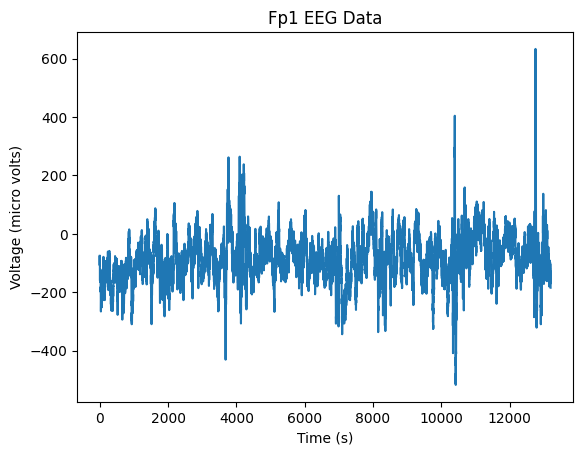

In [4]:

# Taking a sample column to visualize how the data is like, usually we would look at a smaller range of time values, to see the data better
eeg_visualization.loc[:,"Fp1"].plot(xlabel="Time (s)", ylabel="Voltage (micro volts)", title="Fp1 EEG Data")

# Visualizing for Spectrograms

The Spectrograms gives a much in depth analysis into an EEG report. It is a segment of the EEG report, where we see a fourier-transformed analysis of frequencies and their corresponging amplitudes. 

I research a few ideal cases, where certain patterns in spectrograms can be used to infer results.

Usually, spectrogram data is plotted in a heat map, where our main focus is on the red portion (called flames)

![A sample image of a spectrogram](sampleSpectrogram.png)

The deeper colour of red is a query of interest as well. It corresponds to the amplitude/absolute value of the EEG report at a particular point, with a particular given frequency.

In our given spectrogram dataset, we are given a dataset of size 320x401 at an average. 1 of those columns is what defines actual time in seconds, so we have 400 columns of interest.

Columns are divided into 4 parts, LL, RL, LP, RP (Left Lateral, Right Lateral, Left Parasagittal, Right Parasagittal).

Each of the 4 parts have their own range of frequencies. In the above image imagine horizontal slices, which correspond to a particular frequency. That is what is meant by something like LL_0.59. It's a left lateral data at frequency of 0.59 Hz.

Each data point is an absolute value of the amplitude, and the shade of red matters. I will discuss below common cases that help us.

In [5]:
spectrogram_visualization = pd.read_parquet(r'sample_spectrogram.parquet', engine='pyarrow')
spectrogram_visualization.columns

Index(['time', 'LL_0.59', 'LL_0.78', 'LL_0.98', 'LL_1.17', 'LL_1.37',
       'LL_1.56', 'LL_1.76', 'LL_1.95', 'LL_2.15',
       ...
       'RP_18.16', 'RP_18.36', 'RP_18.55', 'RP_18.75', 'RP_18.95', 'RP_19.14',
       'RP_19.34', 'RP_19.53', 'RP_19.73', 'RP_19.92'],
      dtype='object', length=401)

In [6]:
spectrogram_visualization.head()

,time,LL_0.59,LL_0.78,LL_0.98,LL_1.17,LL_1.37,LL_1.56,LL_1.76,LL_1.95,LL_2.15,...,RP_18.16,RP_18.36,RP_18.55,RP_18.75,RP_18.95,RP_19.14,RP_19.34,RP_19.53,RP_19.73,RP_19.92
0,1,4.26,10.98,9.05,13.65,11.49,8.930000,18.840000,19.26,19.240000,...,0.31,0.17,0.28,0.19,0.24,0.27,0.29,0.16,0.22,0.19
1,3,2.65,3.97,12.18,13.26,14.21,13.230000,9.650000,8.11,11.280000,...,0.15,0.13,0.14,0.24,0.24,0.36,0.35,0.31,0.36,0.40
2,5,4.18,4.53,8.77,14.26,13.36,16.559999,19.219999,17.51,22.650000,...,0.29,0.21,0.16,0.25,0.28,0.28,0.34,0.48,0.44,0.48
3,7,2.41,3.21,4.92,8.07,5.97,12.420000,10.820000,14.96,21.809999,...,0.33,0.51,0.49,0.64,0.58,0.42,0.32,0.31,0.32,0.33
4,9,2.29,2.44,2.77,4.62,5.39,7.080000,9.840000,12.27,14.410000,...,0.44,0.38,0.48,0.63,0.45,0.45,0.49,0.33,0.31,0.34


<Axes: title={'center': 'Spectrogram Data Over all 4 Brain Regions'}, xlabel='Frequency (Hz)', ylabel='Power (dB)'>

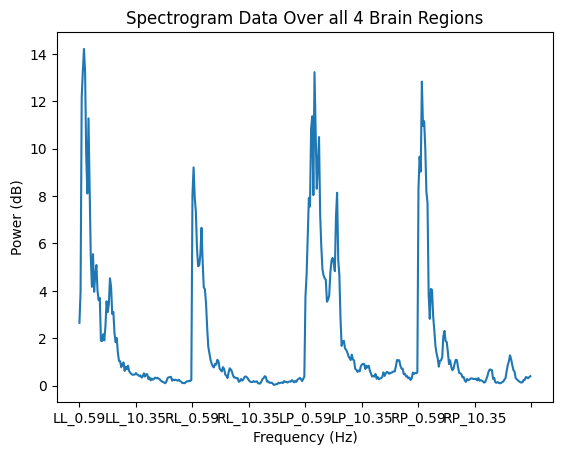

In [7]:
spectrogram_visualization.loc[1,"LL_0.59":].plot(xlabel="Frequency (Hz)", ylabel="Power (dB)", title="Spectrogram Data Over all 4 Brain Regions")

<Axes: >

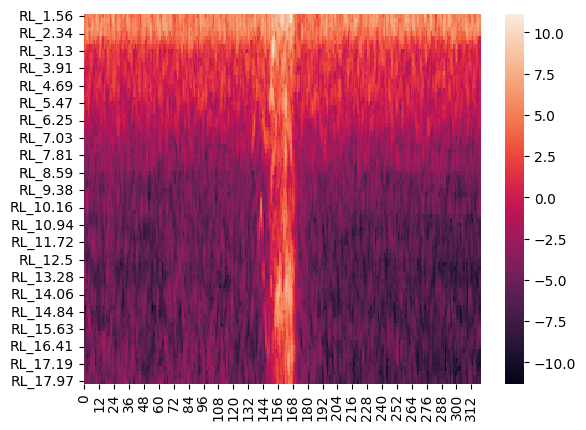

In [8]:
# Note, I have made the graphs upside down, the lower frequencies should be at the bottom
sns.heatmap(2*np.log2(spectrogram_visualization.loc[:,"RL_1.56":"RL_17.97"].T))

<Axes: >

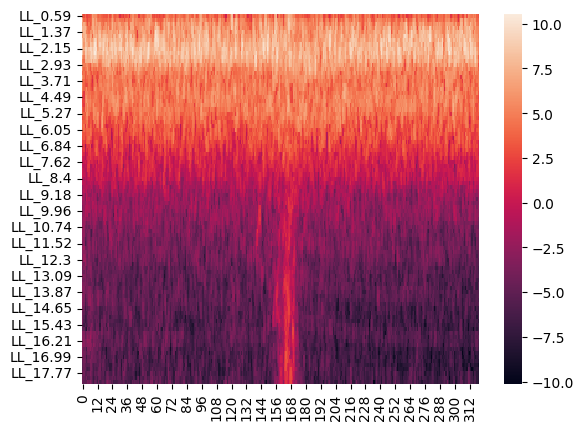

In [9]:
sns.heatmap(2*np.log2(spectrogram_visualization.loc[:,"LL_0.59":"LL_18.16"].T))

Spectograms can have flames (red patches that show growth and decline), and based on their behaviour, we can predict:

- Regular flames: Seizures

![How Seizures look in a Spectrogram](seizuresRegularFlames.png)

- High Power Flames all over the data set: Something Generalized
- Spikey: Something Periodic
- Long Stretches/Broach Band Monotonous: GPDs

![How GPDs look in a Spectrogram](GPDBroadBandMonotonous.png)

- Long Streches/Broach Band Monotonous but only on one side (left or right): LPDs

![How LPDs look in a Spectrogram](LPDBroadBandMonotonous.png)

- Narrow Band Monotonous: GRDA

![How GRDAs look in a Spectrogram](GRDANarrowBandMonotonous.png)

- Narrow Band Monotonous but only on one side: LRDA

![How LRDAs look in a Spectrogram](LRDANarrowBandMonotonous.png)

# What should be the input data in our model?

According to train.csv, we are given the following data at the very least

- eeg_id, [int]
- eeg_sub_id, [int]
- eeg_label_offset_seconds, [int]
- spectrogram_id, [int]
- spectrogram_sub_id, [int]
- spectrogram_label_offset_seconds, [int]
- label_id, [int]
- patient_id, [int]
- expert_consensus, [string]
- seizure_vote, [int]
- lpd_vote, [int]
- gpd_vote, [int]
- lrda_vote, [int]
- grda_vote, [int]
- other_vote [int]

Which makes a total of 15 data points. But there will be more, considering eeg and spectrogram data.



# Transforming the EEG by Fourier Transforms

#### How FFT works
&nbsp;

In [10]:
time_step = 0.05
time_vec = np.arange(0, 10, time_step)
period = 5

# Creating a signal, adding random sin waves and adding some noise
sig = (
        np.sin(2 * np.pi * time_vec / period) 
        + 0.25 * np.random.randn(time_vec.size)
        + np.sin(10 * np.pi * time_vec / period)
        + np.sin(1000 * np.pi * time_vec / period + 90000000)
)

print(np.round(sig, 2))

[-0.52 -0.35 -0.47  0.57  0.59  0.28  0.97 -0.07  0.02  0.09  0.03 -0.42
 -0.26 -0.79 -0.84 -0.85 -0.84 -0.57 -0.73 -0.23  0.39  0.29  0.91  0.99
  1.08  0.98  1.16  1.03  0.89  0.65  0.46 -0.34 -0.44 -0.46 -0.51 -1.09
 -0.98 -0.69 -0.74 -0.51 -0.33 -0.15 -0.12  0.78  0.61  0.96  0.64  0.39
  0.52 -0.48 -0.54 -0.93 -0.79 -1.55 -2.09 -1.98 -2.12 -2.28 -1.68 -1.96
 -1.58 -1.37 -0.79 -0.62 -0.45 -0.25 -0.66 -0.92 -1.06 -1.25 -1.3  -1.78
 -2.31 -2.4  -2.86 -2.34 -2.82 -2.68 -2.21 -1.67 -1.54 -1.39 -0.92 -0.99
 -0.63 -0.56 -0.89 -1.44 -0.78 -0.91 -1.72 -1.79 -1.31 -1.99 -2.02 -1.92
 -1.66 -1.34 -1.55 -0.87 -0.44 -0.01 -0.11 -0.12  0.57  0.3   0.3   0.36
  0.31  0.23 -0.21 -0.27 -1.37 -0.33 -0.42 -1.19 -0.9  -0.4  -0.51  0.31
  0.32  0.26  1.09  1.28  1.11  1.49  1.84  0.82  1.04  0.46  0.48 -0.37
 -0.25 -0.96 -0.76 -0.5  -1.   -0.6  -0.79 -0.47 -0.45 -0.15  0.41  0.37
  0.51  0.54  0.35  0.18  0.13 -0.52 -0.97 -1.28 -1.57 -1.53 -2.27 -2.15
 -2.07 -1.49 -1.68 -1.63 -1.23 -0.95 -1.07 -0.53 -0

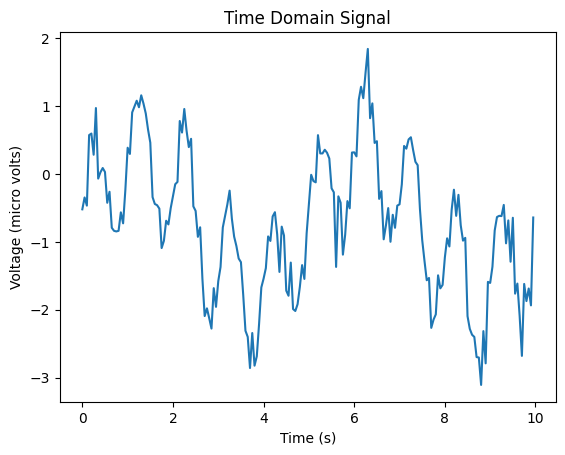

In [11]:
plt.plot(time_vec, sig)
plt.xlabel("Time (s)")
plt.ylabel("Voltage (micro volts)")
plt.title("Time Domain Signal")
plt.show()

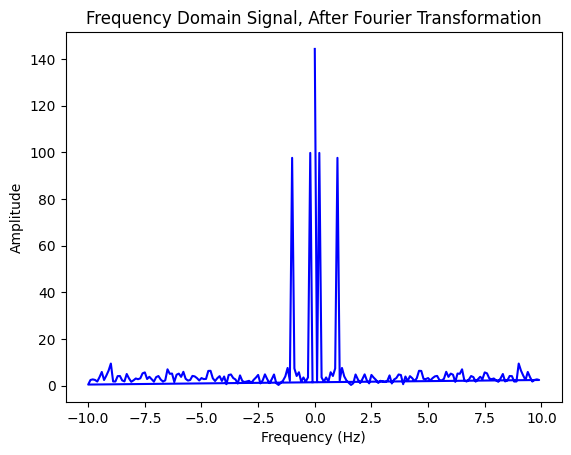

In [12]:
# Taking the fourier transform of the signal
sig_fft = fftpack.fft(sig)

# Finding the ampltiudes, powers and angles
Amplitude = np.abs(sig_fft)
Power = Amplitude**2
Angle = np.angle(sig_fft)

# Finding the sample frequency and the peak frequency
sample_freq = fftpack.fftfreq(sig.size, d=time_step)
Amp_freq = np.array([Amplitude, sample_freq])
peak_frequency_list = np.sort(Amp_freq[1])[-10:]

plt.plot(sample_freq, Amplitude, label="Fourier Transform", color="blue")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Amplitude")
plt.title("Frequency Domain Signal, After Fourier Transformation")
plt.show()


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


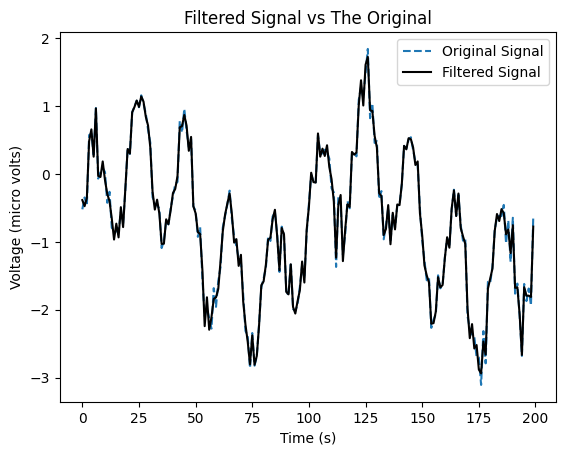

In [13]:
# Filtering the signal
high_freq_fft = sig_fft.copy()
high_freq_fft[np.abs(sample_freq) > np.min(peak_frequency_list)] = 0
filtered_sig = fftpack.ifft(high_freq_fft)

plt.plot(sig, label="Original Signal", linestyle="--")
plt.plot(filtered_sig, label="Filtered Signal", color="black")
plt.legend()
plt.xlabel("Time (s)")
plt.ylabel("Voltage (micro volts)")
plt.title("Filtered Signal vs The Original")
plt.show()

# Making a General Function 

In [14]:
# Assumption:   - The eeg_data is a 1D numpy array
#               - The eeg_data is a time series data
#               - The eeg_data comprises of sums of sine or cosine waves (with a little bit of noise)

# This function takes in an EEG data and plots the original signal, calculates the fourier transform and plots the 
# filtered signal.

# fourier_transform_eeg(eeg_data :: np.array, level_of_detail :: int): 
#                           np.array, int -> np.array(2, level_of_detail)

def fourier_transform_eeg(eeg_data, level_of_detail=10):
    # Input validation
    if not isinstance(eeg_data, np.ndarray) or eeg_data.ndim != 1:
        raise ValueError("Input 'eeg_data' must be a 1D NumPy array.")

    # Plotting the time domain signal of the Original EEG data
    plt.plot(eeg_data)
    plt.xlabel("Time (s)")
    plt.ylabel("Voltage (micro volts)")
    plt.title("Time Domain Signal")
    plt.show()

    # Taking the Fourier transform of the signal
    eeg_data_fft = fftpack.fft(eeg_data)

    # Finding the amplitudes and frequencies
    amplitudes = np.abs(eeg_data_fft)
    sample_freq = fftpack.fftfreq(eeg_data.size)

    # Finding the top peaks in the frequency domain
    peak_indices = np.argsort(amplitudes)[::-1][:level_of_detail]
    output_amplitude_and_frequency = np.array([amplitudes[peak_indices], sample_freq[peak_indices]])


    # Plotting the Fourier Transform
    plt.plot(sample_freq, amplitudes, label="Fourier Transform", color="blue")
    plt.scatter(sample_freq[peak_indices], amplitudes[peak_indices], color='red', label='Top Peaks')
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Amplitude")
    plt.title("Frequency Domain EEG Data, After Fourier Transformation")
    plt.legend()
    plt.show()

    # Reconstructing the filtered signal using the inverse Fourier transform
    filtered_eeg_data = fftpack.ifft(np.where(np.isin(sample_freq, output_amplitude_and_frequency[1]), eeg_data_fft, 0))

    # Plotting the filtered signal
    plt.plot(eeg_data, label="Original Signal", linestyle="--")
    plt.plot(filtered_eeg_data.real, label="Filtered Signal", color="black")
    plt.legend()
    plt.xlabel("Time (s)")
    plt.ylabel("Voltage (micro volts)")
    plt.title("Filtered Signal vs The Original")
    plt.show()

    return output_amplitude_and_frequency

# Looking how it works in other models

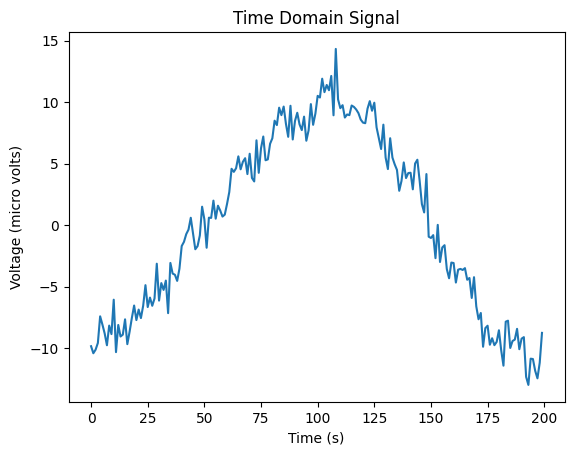

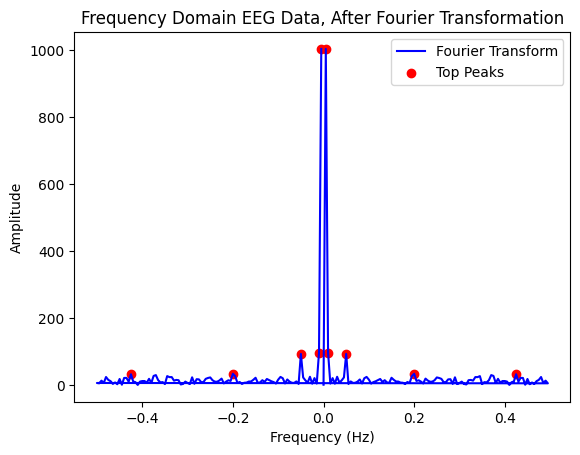

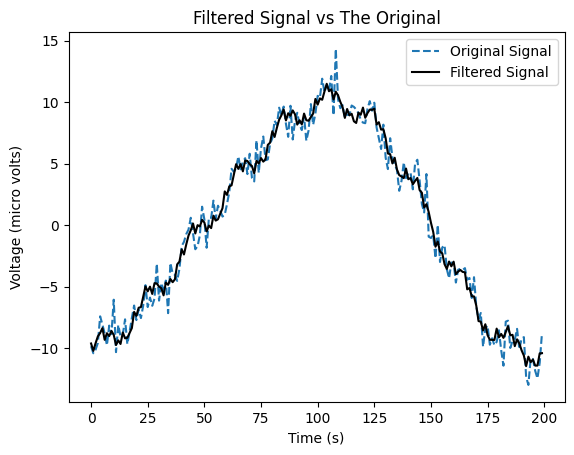

Transformed Sig:  [[ 1.00275919e+03  1.00275919e+03  9.72311344e+01  9.72311344e+01
   9.31786330e+01  9.31786330e+01  3.39173707e+01  3.39173707e+01
   3.25311059e+01  3.25311059e+01]
 [-5.00000000e-03  5.00000000e-03  1.00000000e-02 -1.00000000e-02
  -5.00000000e-02  5.00000000e-02  2.00000000e-01 -2.00000000e-01
   4.25000000e-01 -4.25000000e-01]]


In [15]:
# It works for other models too!

sig = (
        np.sin(2 * np.pi * time_vec / period) 
        + np.random.randn(time_vec.size)
        + np.sin(10 * np.pi * time_vec / period)
        + -10 * np.sin(np.pi * time_vec / period + np.pi / 2)
        + 0.5 * np.sin(10000 * np.pi * time_vec / period)
)

sig_fourier = fourier_transform_eeg(sig)
print("Transformed Sig: ", sig_fourier)


# Applying Fourier Transforms to our EEG Samples

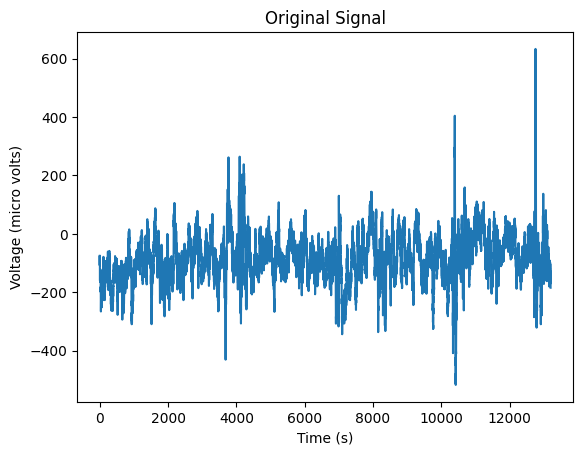

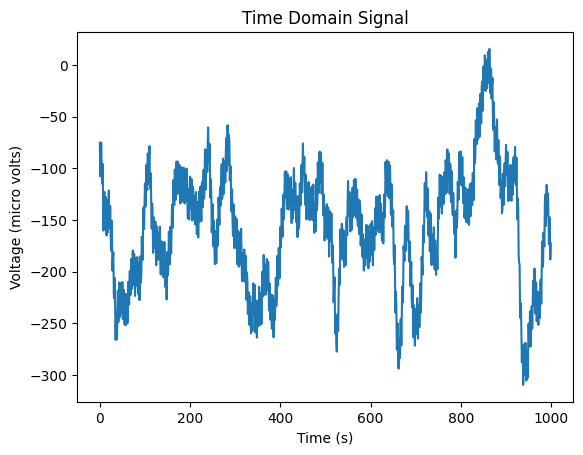

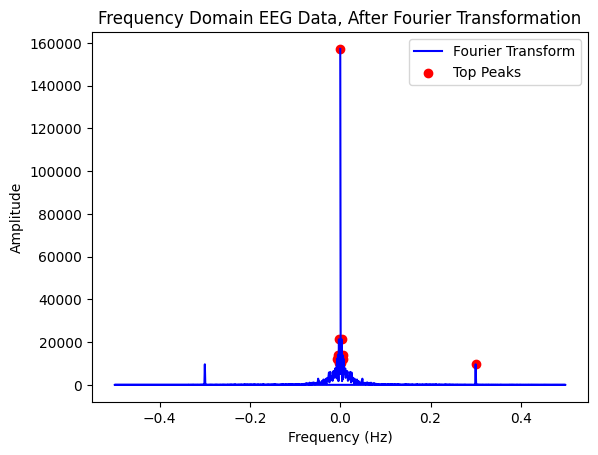

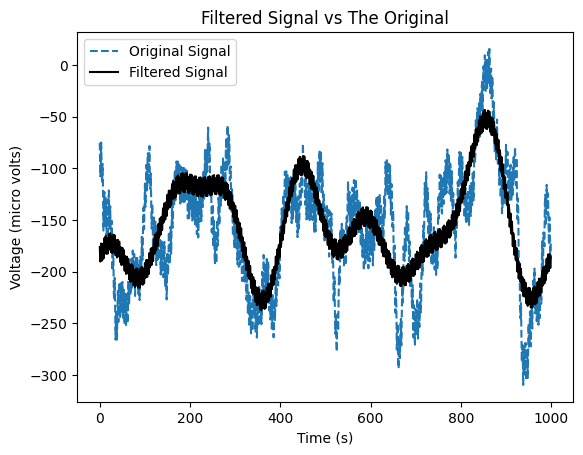

Transformed EEG:  [[ 1.57196578e+05  2.13255000e+04  2.13255000e+04  1.39674766e+04
   1.39674766e+04  1.22796279e+04  1.22796279e+04  1.01605957e+04
   1.01605957e+04  9.63996582e+03]
 [ 0.00000000e+00  3.00000000e-03 -3.00000000e-03 -5.00000000e-03
   5.00000000e-03  7.00000000e-03 -7.00000000e-03 -2.00000000e-03
   2.00000000e-03  3.00000000e-01]]


In [16]:
eeg_visualization_Fp1 = np.array(eeg_visualization.loc[:,"Fp1"])
plt.plot(eeg_visualization_Fp1, label="Original Signal")
plt.xlabel("Time (s)")
plt.ylabel("Voltage (micro volts)")
plt.title("Original Signal")
plt.show()

# Let's take smaller portion of the signal
eeg_visualization_Fp1 = eeg_visualization_Fp1[0:1000]
eeg_fourier = fourier_transform_eeg(eeg_visualization_Fp1)
print("Transformed EEG: ", eeg_fourier)

# Adding Artifacts

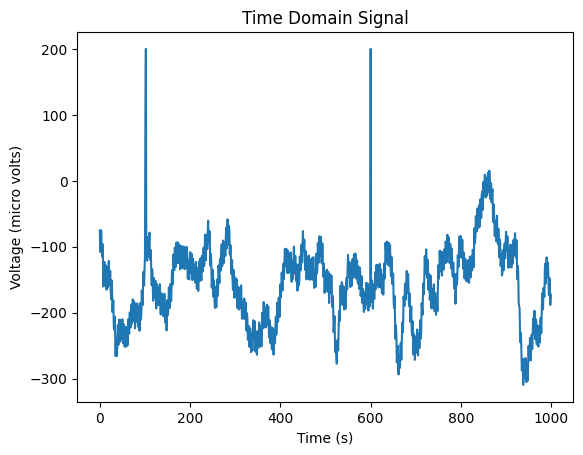

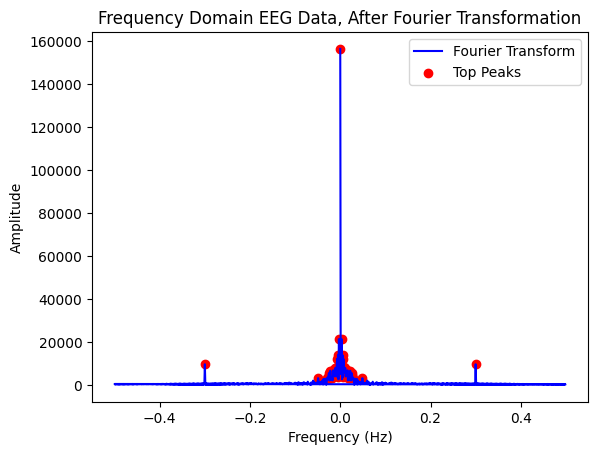

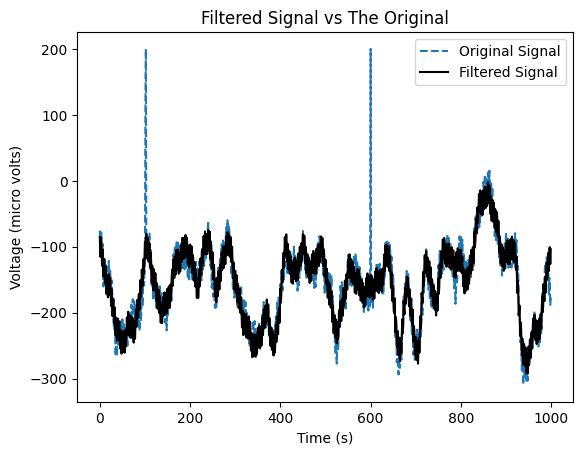

Transformed EEG 2:  [[ 1.56278812e+05  2.13464297e+04  2.13464297e+04  1.38891104e+04
   1.38891104e+04  1.21439531e+04  1.21439531e+04  9.64221191e+03
   9.64221191e+03  9.36878027e+03  9.36878027e+03  8.32076270e+03
   8.32076270e+03  7.94539795e+03  7.94539795e+03  7.64160645e+03
   7.64160645e+03  6.83293115e+03  6.83293115e+03  6.61978906e+03
   6.61978906e+03  5.85896729e+03  5.85896729e+03  5.66436328e+03
   5.66436328e+03  5.58582129e+03  5.58582129e+03  5.15578174e+03
   5.15578174e+03  4.98239111e+03  4.98239111e+03  4.67760645e+03
   4.67760645e+03  4.61163379e+03  4.61163379e+03  4.49190918e+03
   4.49190918e+03  3.99465186e+03  3.99465186e+03  3.63648999e+03
   3.63648999e+03  3.47727808e+03  3.47727808e+03  3.40174414e+03
   3.40174414e+03  3.36348291e+03  3.36348291e+03  3.19139331e+03
   3.19139331e+03  2.91290503e+03]
 [ 0.00000000e+00 -3.00000000e-03  3.00000000e-03  5.00000000e-03
  -5.00000000e-03 -7.00000000e-03  7.00000000e-03 -3.00000000e-01
   3.00000000e-01 -2.

In [17]:
# Adding artifcats
eeg_visualization_Fp1[101] = 100
eeg_visualization_Fp1[102] = 200
eeg_visualization_Fp1[600] = 200
eeg_2_fourier = fourier_transform_eeg(eeg_visualization_Fp1, 50)

print("Transformed EEG 2: ", eeg_2_fourier)

# Looking at the bigger picture

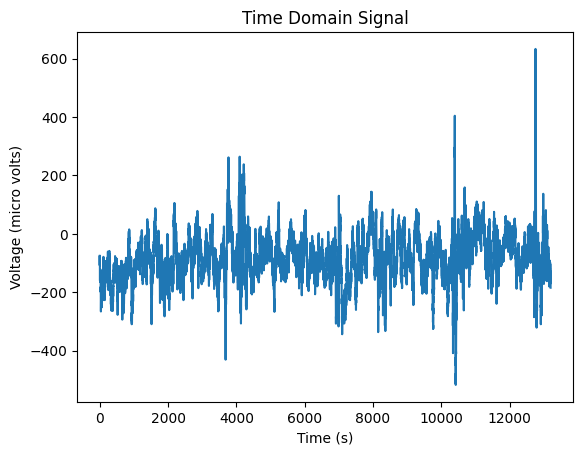

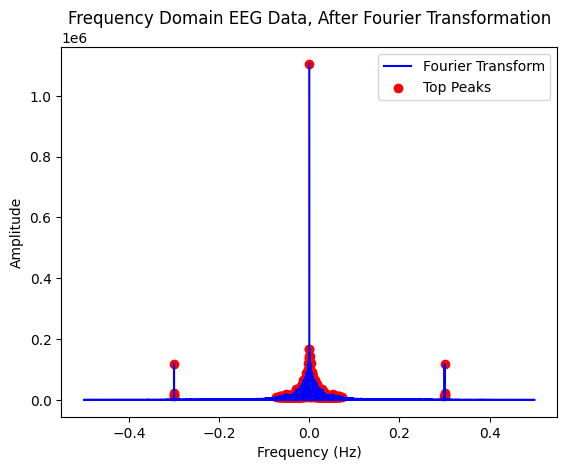

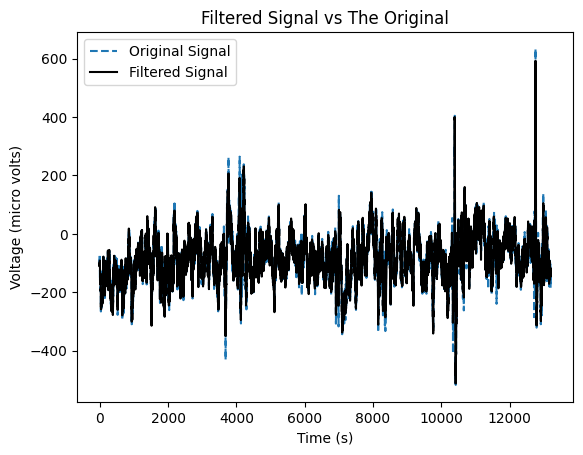

Transformed EEG 3:  [[ 1.10468712e+06  1.66970438e+05  1.66970438e+05 ...  9.35136523e+03
   9.35136523e+03  9.35121680e+03]
 [ 0.00000000e+00  1.51515152e-04 -1.51515152e-04 ...  3.22727273e-02
  -3.22727273e-02 -6.62121212e-02]]


In [18]:
# Looking at the bigger picture
eeg_3_fourier = fourier_transform_eeg(np.array(eeg_visualization.loc[:,"Fp1"]), 1000)

print("Transformed EEG 3: ", eeg_3_fourier)

# Who gives a damn?

Instead of dealing with a size of 

In [19]:

print(eeg_visualization.loc[:,"Fp1"].size)

13200


We can deal with a smaller size of

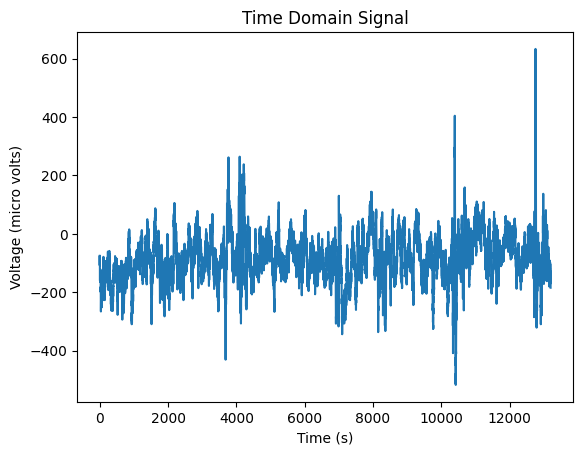

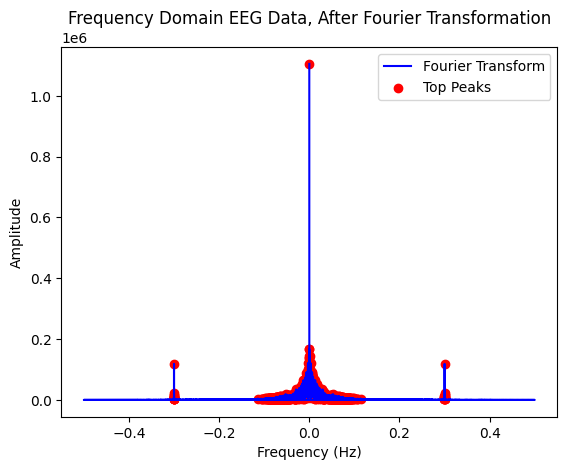

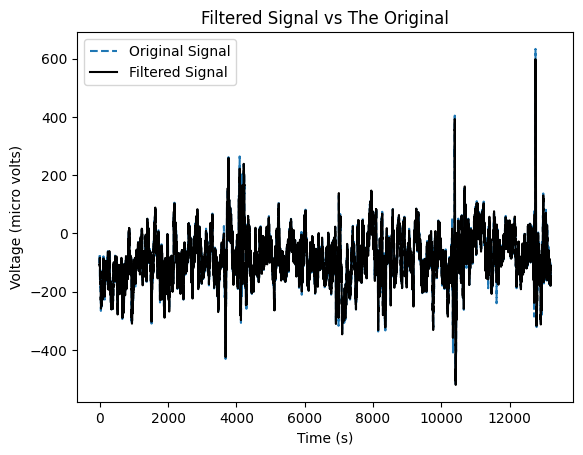

4000


In [20]:

print(fourier_transform_eeg(np.array(eeg_visualization.loc[:,"Fp1"]), 2000).size)


We have also dealt with Data Standardization and Data Imputation using fourier series

Plus, now we have the complete information only using the frequencies and ampltidues in sin waves.